In [1]:
from optimized_full_SVMM import SVMM
from pandas import read_csv
from scipy.stats import geom, norm, multinomial, expon, truncnorm
import matplotlib.pyplot as plt 
import numpy as np
from joblib import Parallel, delayed
from sklearn.cluster import KMeans as km
import seaborn as sns

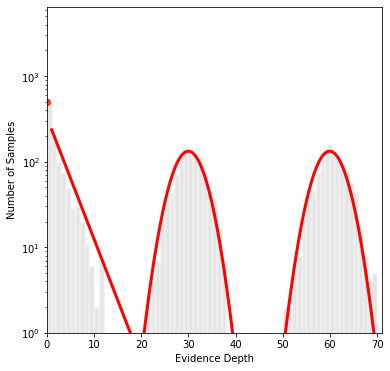

In [2]:
file_name = 'test_3mode.csv'
file = read_csv('../data/'+file_name, header = None)
X = file.values[0]
N = len(X)
pi, alpha, lambda_, mu, sigma = SVMM(X, True, False)

In [3]:
def theta_to_data(N, pi, alpha, lambda_, mu_2, sigma):

    draws = multinomial.rvs(n = N, p = pi)
    draws_alpha = multinomial.rvs(n = draws[0], p = [alpha, 1 - alpha])

    X = [0 for _ in range(draws_alpha[0])]
    X_l = geom.rvs(1/lambda_, size = draws_alpha[1])
    X_g = norm.rvs(mu_2, sigma[0], size = draws[1])
    X_g2 = norm.rvs(2 * mu_2, sigma[1], size = draws[2])

    while sum(X_g < -0.5) > 0:
        X_g_new = norm.rvs(mu_2, sigma[0], size = sum(X_g < -0.5))
        X_g = [x for x in X_g if x >= -0.5]
        X_g = np.concatenate((X_g, X_g_new))

    while sum(X_g2 < -0.5) > 0:
        X_g2_new = norm.rvs(2 * mu_2, sigma[1], size = sum(X_g2 < -0.5))
        X_g2 = [x for x in X_g2 if x >= -0.5]
        X_g2 = np.concatenate((X_g2, X_g2_new))

    X = np.concatenate((X,X_l))
    X = np.concatenate((X,X_g))
    X = np.concatenate((X,X_g2))
    X = np.round(X).astype(int)

    return X

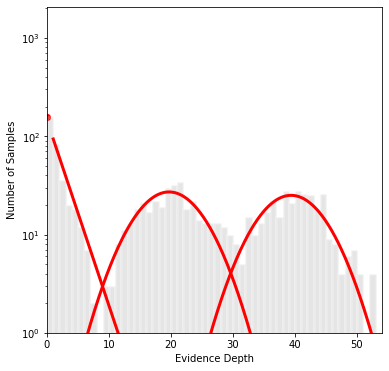

(array([0.33324983, 0.34667486, 0.32007531]),
 0.46807000259726617,
 2.3022371373435013,
 array([19.68227821, 39.36455643]),
 [5.098447848085994, 5.098447848085994])

In [4]:
N = 1000
pi = [1/3, 1/3, 1/3]
alpha = 0.5
lambda_ = 2
mu_2 = 20
sigma = [5, 5]

X_gen = theta_to_data(N, pi, alpha, lambda_, mu_2, sigma)
SVMM(X_gen, True, False)

In [5]:
def X_rvs_left(mu, sigma, len, cut):
    X_delta = norm.rvs(loc = mu, scale = sigma, size = len)
    while sum(X_delta < cut) > 0:
        X_delta_new = norm.rvs(loc = mu, scale = sigma, size = sum(X_delta < cut))
        X_delta = [x for x in X_delta if x >= cut]
        X_delta = np.concatenate((X_delta, X_delta_new))
    return X_delta

true mu2: 10


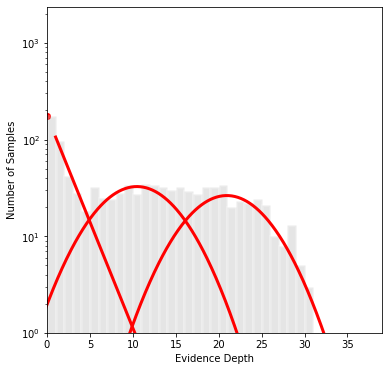

sigma estimation: 4.415004750287176
lambda_estimation: 1.9772762799483437
initial 2mu2: 20.940457665883613
refined 2mu2: 21.04390594174568


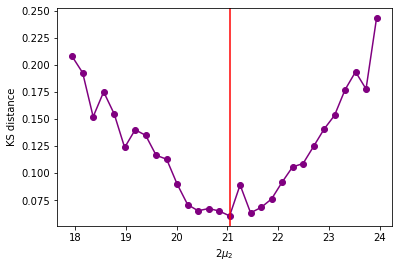

true mu2: 11


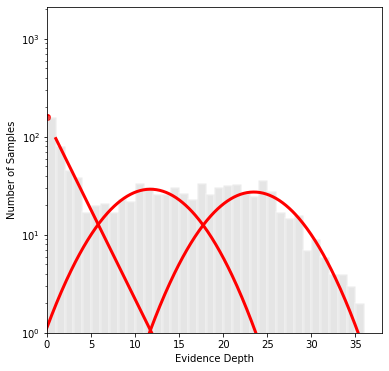

sigma estimation: 4.60587685293408
lambda_estimation: 2.3839404622649774
initial 2mu2: 23.467244481418476
refined 2mu2: 23.363796205556408


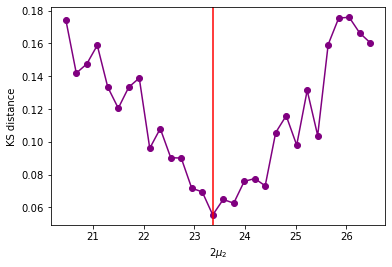

true mu2: 12


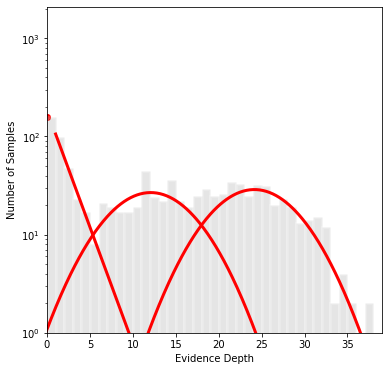

sigma estimation: 4.768459085066102
lambda_estimation: 1.8313356026684602
initial 2mu2: 24.15075984200007
refined 2mu2: 24.254208117862138


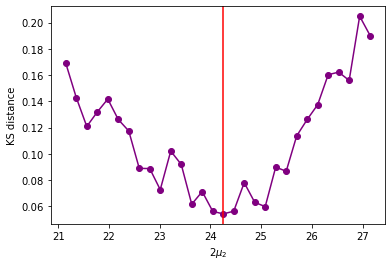

true mu2: 13


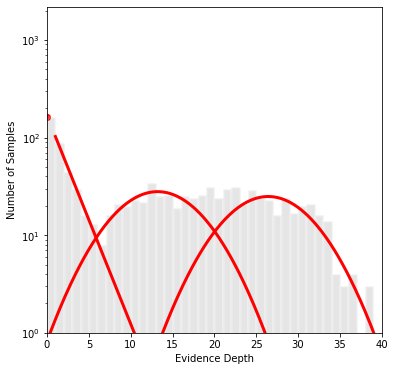

sigma estimation: 4.973521497821479
lambda_estimation: 2.0349250339371316
initial 2mu2: 26.423044844260694
refined 2mu2: 26.526493120122762


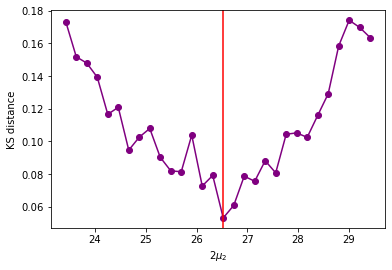

true mu2: 14


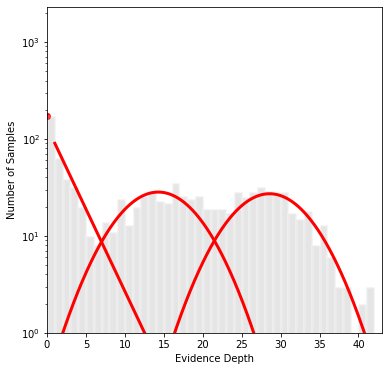

sigma estimation: 4.741608526247104
lambda_estimation: 2.5610759123177753
initial 2mu2: 28.57593088830741
refined 2mu2: 29.300068819341895


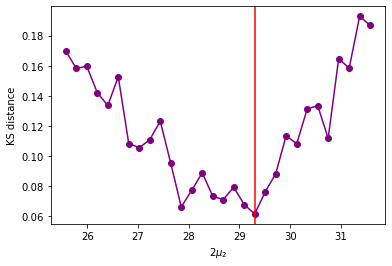

true mu2: 15


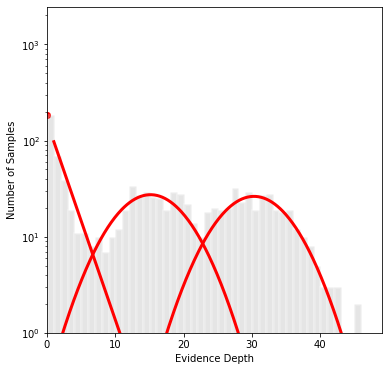

sigma estimation: 4.99266072375209
lambda_estimation: 2.108315767612108
initial 2mu2: 30.288696228400077
refined 2mu2: 30.18524795253801


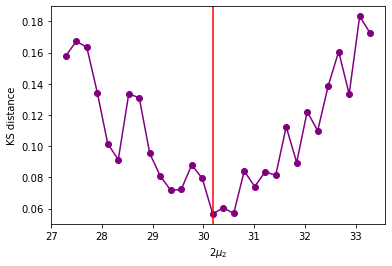

In [6]:
def ks_distance_svmm(X_gen, show_plot, refine_factor):
    theta = SVMM(X_gen, True, False) 
    mu2_times2 = theta[3][1] 
    sigma_3 = theta[4][1]
    print('sigma estimation:',sigma_3)
    print('lambda_estimation:',theta[2])
    print('initial 2mu2:',mu2_times2)
    Y_gen = [x for x in X_gen if x >= mu2_times2] # all observations >= 2mu2
    EDF_y = np.arange(1,len(Y_gen)+1)/float(len(Y_gen))
    mu2times2hat_range = np.linspace(mu2_times2 - 3, mu2_times2 + 3, 30)
    d_range_squared = []
    for _ in range(refine_factor):
        d_range = []
        for delta in mu2times2hat_range:
            X_delta = X_rvs_left(delta, sigma_3, len(Y_gen), mu2_times2)
            CDF_x = truncnorm.cdf(np.sort(X_delta), a=0, b=np.inf, loc=mu2_times2, scale=sigma_3)
            diffs = [abs(cdf_val - edf_val) for cdf_val, edf_val in zip(CDF_x, EDF_y)]
            d_range.append(max(diffs))
        d_range_squared.append(d_range)
    d_range = np.average(d_range_squared, axis=0)
    best_mu = mu2times2hat_range[np.where(d_range == (min(d_range)))]
    print('refined 2mu2:', best_mu[0])
    # PLOT D AGAINST 2MU_2
    if show_plot:
        plt.plot(mu2times2hat_range, d_range, '-o', color = 'purple')
        plt.axvline(best_mu, color='red')
        plt.xlabel(r'$2\mu_2$')
        plt.ylabel('KS distance')
        plt.show()
    return best_mu
for mu2 in range(10,16):
    print('true mu2:',mu2)
    X_gen = theta_to_data(N, pi, alpha, lambda_, mu2, sigma)
    ks_distance_svmm(X_gen, True, 5)

In [7]:
def plot_SVMM_gmm(X, n, pi, mu, sigma):
    ax = plt.subplots(figsize = (6,6))[1]
    plt.hist(X, alpha = 0.20, bins = max(X), color = 'grey', edgecolor = 'white', linewidth = 3) # plot histogram of input data set

    curve2 = np.linspace(mu[0] - 10 * sigma[0], mu[0] + 10 * sigma[0], 1000)
    curve3 = np.linspace(mu[1] - 10 * sigma[1], mu[1] + 10 * sigma[1], 1000)
    plt.plot(curve2, n * norm.pdf(curve2, mu[0], sigma[0]) * pi[0], linewidth = 3, color='red')
    plt.plot(curve3, n * norm.pdf(curve3, mu[1], sigma[1]) * pi[1], linewidth = 3, color='red')

    ax.set_yscale("log") 
    ax.set_ylim(bottom=1)
    ax.set_xlim(left=0, right = max(X)+1)
    plt.xlabel('Evidence Depth')
    plt.ylabel('Number of Samples')
    plt.show()

def SVMM_gmm(X, show_plot, show_distance):

    # TODO: fine-tune initial paramters, put in separate function
    # initial values for parameters
    n = np.shape(X)[0] # length of data set
    pi = [1.0/2 for _ in range(2)] # mixing coefficients
    r = np.zeros([2,n]) # responsibility matrix
    sigma = [np.std(X), np.std(X)] # standard deviation for normal distribution
    f = np.ravel(X).astype(float)
    f=f.reshape(-1,1)
    kmeans = km(n_clusters=2)
    kmeans.fit(f)
    centers = np.sort(np.ravel(kmeans.cluster_centers_))
    # mu = [max(X)/3.0, 2.0*max(X)/3.0]
    mu = centers
    log_likelihoods = [] 
    iteration = 0
    distance = 1

    while distance > (1/(n*10)): # convergence criterion

        # expectation
        r[0] = pi[0] * norm.pdf(X, mu[0], sigma[0]) # responsibility of each value to second component
        r[1] = pi[1] * norm.pdf(X, mu[1], sigma[1]) # responsibility of each value to second component
        r = r / np.sum(r, axis = 0) # normalization
        
        # maximization
        pi = np.sum(r, axis = 1) / n # total responsibility of a component divided by total # of observations
        mu[0] = np.average(X, weights = r[0]) # MLE for mean in normal distribution
        mu[1] = np.average(X, weights = r[1]) # MLE for mean in normal distribution
        mu[0] = (mu[0] + 0.5*mu[1])/2
        mu[1] = 2*mu[0]
        sigma[0] = np.average((X-mu[0])**2, weights=r[0])**.5 # MLE for standard deviation in normal distribution
        sigma[1] = np.average((X-mu[1])**2, weights=r[1])**.5 # MLE for standard deviation in normal distribution
        sigma[0] = (sigma[0] + sigma[1]) / 2.0
        sigma[1] = sigma[0]

        # score
        gmm = pi[0] * norm.pdf(X, mu[0], sigma[0]) +  pi[1] * norm.pdf(X, mu[1], sigma[1])# likelihood of each observation in normal distribution
        log_likelihood = np.sum(np.log(gmm)) # sum of log of likelihood of each observation
        log_likelihoods.append(log_likelihood) 

        iteration += 1
        if iteration > 1:
            distance = np.abs(log_likelihoods[-2]-log_likelihoods[-1]) # magnitude of difference between each 
            if(show_distance):
                print(distance)

    if(show_plot):
        plot_SVMM_gmm(X, n, pi, mu, sigma)

    return pi, mu, sigma

In [8]:
def theta_to_data_nm1(N, pi, mu_2, sigma):
# without first mode
    draws = multinomial.rvs(n = N, p = pi)
    
    X = []
    X_g = norm.rvs(mu_2, sigma[0], size = draws[0])
    X_g2 = norm.rvs(2 * mu_2, sigma[1], size = draws[1])

    while sum(X_g < -0.5) > 0:
        X_g_new = norm.rvs(mu_2, sigma[0], size = sum(X_g < -0.5))
        X_g = [x for x in X_g if x >= -0.5]
        X_g = np.concatenate((X_g, X_g_new))

    while sum(X_g2 < -0.5) > 0:
        X_g2_new = norm.rvs(1.1 * mu_2, sigma[1], size = sum(X_g2 < -0.5))
        X_g2 = [x for x in X_g2 if x >= -0.5]
        X_g2 = np.concatenate((X_g2, X_g2_new))

    X = np.concatenate((X,X_g))
    X = np.concatenate((X,X_g2))
    X = np.round(X).astype(int)
    return X

mu2: 10


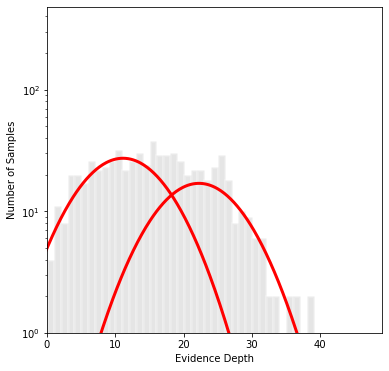

(array([0.616634, 0.383366]), array([11.11909594, 22.23819187]), [6.023513581478086, 6.023513581478086])
mu2: 11


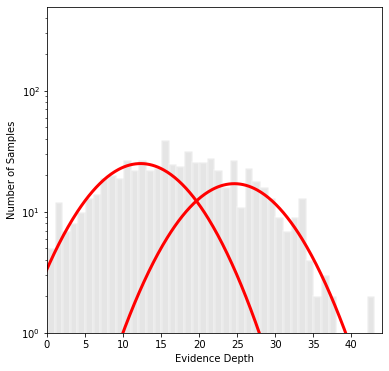

(array([0.5945512, 0.4054488]), array([12.30395326, 24.60790653]), [6.143451913474555, 6.143451913474555])
mu2: 12


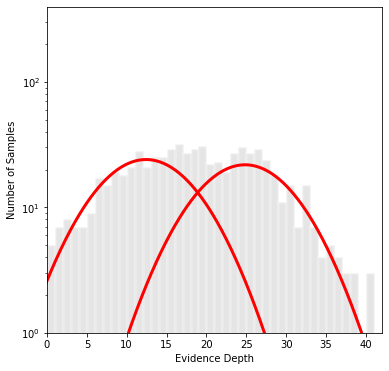

(array([0.52406346, 0.47593654]), array([12.41944717, 24.83889433]), [5.889978563538669, 5.889978563538669])
mu2: 13


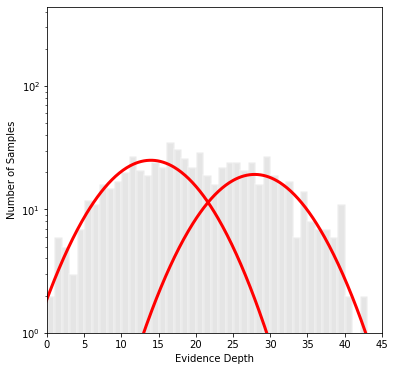

(array([0.56569691, 0.43430309]), array([13.95462868, 27.90925736]), [6.13657504209073, 6.13657504209073])
mu2: 14


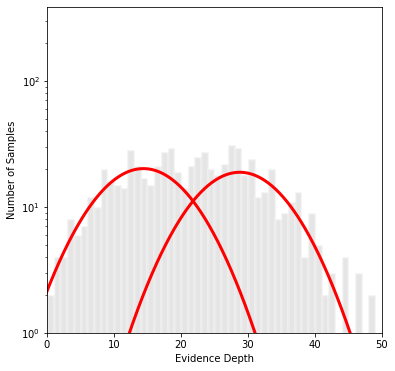

(array([0.51675566, 0.48324434]), array([14.39217032, 28.78434064]), [6.805008116040517, 6.805008116040517])
mu2: 15


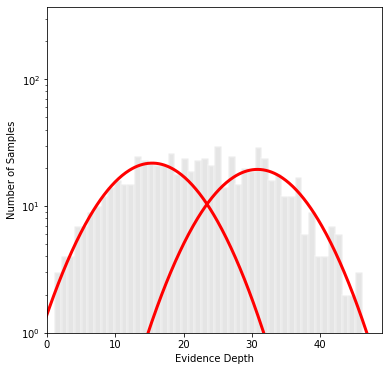

(array([0.52852202, 0.47147798]), array([15.39838888, 30.79677775]), [6.571033379969466, 6.571033379969466])


In [9]:
N = 1000
pi = [1/3, 1/3, 1/3]
sigma = [7, 7]

for mu_2 in range(10,16):
    print('mu2:',mu_2)
    X_gen = theta_to_data_nm1(N, pi, mu_2, sigma)
    print(SVMM_gmm(X_gen, True, False))

In [5]:
def single_run(N, pi, alpha, lambda_, mu, sigma):
    X_gen = theta_to_data(N, pi, alpha, lambda_, mu, sigma)
    mu_2_hat = SVMM(X_gen, False, False)[3][0]
    return mu_2_hat

def plot_mu(N, pi, alpha, lambda_, sigma, start, stop, step):
    mus = np.arange(start, stop, step)
    num_runs = 100
    ests = []
    
    for mu in mus:
        est_i = Parallel(n_jobs=-1)(delayed(single_run)(N, pi, alpha, lambda_, mu, sigma) for _ in range(num_runs))
        ests.append(np.mean(est_i))
        
    return mus, ests

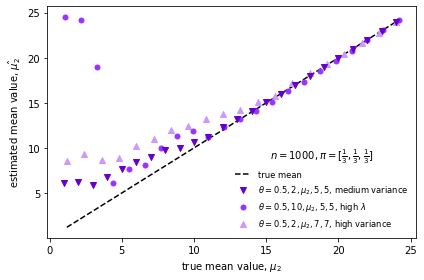

In [7]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)

mus, ests = plot_mu(N, pi, alpha, lambda_, sigma, 1,25,1)
plt.scatter(mus, ests, marker = 'v', color = '#6600CC', label = r'$\theta = {0.5, 2, \mu_2, 5, 5}$, medium variance', zorder = 4)

mus, ests = plot_mu(N, pi, alpha, 6, sigma, 1.1, 25.1,1.1)
plt.scatter(mus, ests, marker = '.', s = 100,color = '#9933FF',label = r'$\theta = {0.5, 10, \mu_2, 5, 5}$, high $\lambda$', zorder = 3)

mus, ests = plot_mu(N, pi, alpha, lambda_, [7,7], 1.2,25.2,1.2)
plt.scatter(mus, ests, marker = '^', color = '#CC99FF', label = r'$\theta = {0.5, 2, \mu_2, 7, 7}$, high variance', zorder = 2)
plt.plot(mus, mus,'--',color = 'black', label = 'true mean', zorder = 1)

ax.set_xlabel(r'true mean value, $\mu_2$')
ax.set_ylabel(r'estimated mean value, $\hat{\mu_2}$')
plt.legend(loc = 'lower right', fontsize = 'small', frameon = False, title = r'$n = 1000, \pi = [\frac{1}{3},\frac{1}{3},\frac{1}{3}]$')
plt.show()
# more general way of showing plot would be to divide by lambda, lose interpretibility

In [8]:
def single_run(N, pi, alpha, lambda_, mu, sigma):
    X_gen = theta_to_data(N, pi, alpha, lambda_, mu, sigma)
    adjusted_mu_2_hat = ks_distance_svmm(X_gen, False, 10)
    return adjusted_mu_2_hat/2.0

def plot_mu(N, pi, alpha, lambda_, sigma, start, stop, step):
    mus = np.arange(start, stop, step)
    num_runs = 100
    ests = []
    for mu in mus:
        print(mu)
        est_i = Parallel(n_jobs=-1)(delayed(single_run)(N, pi, alpha, lambda_, mu, sigma) for _ in range(num_runs))
        ests.append(np.mean(est_i))
        
    return mus, ests

1
initial 2mu2: 8.935677567291911
initial 2mu2: 8.935677567291911
initial 2mu2: 8.936423926128342
initial 2mu2: 8.935677567291911
initial 2mu2: 8.935677567291911
initial 2mu2: 8.936423926128342
initial 2mu2: 8.935677567291911
initial 2mu2: 8.935677567291911
initial 2mu2: 8.935677567291911
initial 2mu2: 8.935677567291911
refined 2mu2: 9.246022394878118
refined 2mu2: 9.246768753714548
refined 2mu2: 9.246022394878118
refined 2mu2: 9.246022394878118
refined 2mu2: 9.246022394878118
refined 2mu2: 9.246768753714548
refined 2mu2: 9.246022394878118
refined 2mu2: 9.246022394878118
refined 2mu2: 9.246022394878118
refined 2mu2: 9.246022394878118
initial 2mu2: 8.935677567291911
initial 2mu2: 8.935677567291911
initial 2mu2: 8.935677567291911
initial 2mu2: initial 2mu2:8.935677567291911 
8.935677567291911
initial 2mu2: 8.935677567291911
initial 2mu2: 8.935677567291911
initial 2mu2: 8.935677567291911
initial 2mu2: 8.935677567291911
initial 2mu2: 8.935677567291911
refined 2mu2: 9.246022394878118
refine

KeyboardInterrupt: 

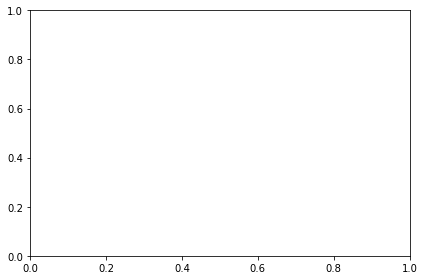

In [9]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)

mus, ests = plot_mu(N, pi, alpha, lambda_, sigma, 1,10,1)
plt.scatter(mus, ests, marker = 'v', color = 'red', label = r'$\theta = {0.5, 2, \mu_2, 5, 5}$, medium variance', zorder = 4)

mus, ests = plot_mu(N, pi, alpha, 10, sigma, 1.1, 10.1,1.1)
plt.scatter(mus, ests, marker = '.', s = 100,color = 'blue',label = r'$\theta = {0.5, 10, \mu_2, 5, 5}$, high $\lambda$', zorder = 3)

mus, ests = plot_mu(N, pi, alpha, lambda_, [7,7], 1.2,10.2,1.2)
plt.scatter(mus, ests, marker = '^', color = 'green', label = r'$\theta = {0.5, 2, \mu_2, 7, 7}$, high variance', zorder = 2)
plt.plot(mus, mus,'--',color = 'black', label = 'true mean', zorder = 1)

ax.set_xlabel(r'true mean value, $\mu_2$')
ax.set_ylabel(r'estimated mean value, $\hat{\mu_2}$')
plt.legend(loc = 'upper right', fontsize = 'small', frameon = False, title = r'$n = 1000, \pi = [\frac{1}{3},\frac{1}{3},\frac{1}{3}]$')
plt.show()

In [4]:
def single_run_l(N, pi, alpha, lambda_, mu, sigma):
    X_gen = theta_to_data(N, pi, alpha, lambda_, mu, sigma)
    mu_2_hat = SVMM(X_gen, False, False)[3][0]
    return mu_2_hat

def plot_lambda(N, pi, alpha, mu, sigma, start, stop, step):
    lambdas = np.arange(start, stop, step)
    num_runs = 100
    ests = []
    
    for lambda_ in lambdas:
        est_i = Parallel(n_jobs=-1)(delayed(single_run_l)(N, pi, alpha, lambda_, mu, sigma) for _ in range(num_runs))
        ests.append(np.mean(est_i))
        
    return lambdas, ests

NameError: name 'plot_lambda' is not defined

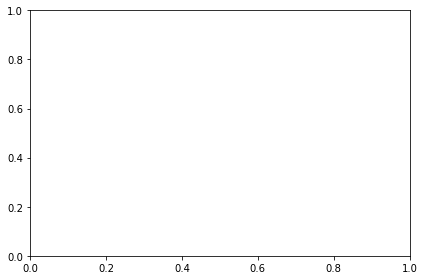

In [9]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)

lambdas, ests = plot_lambda(N, pi, alpha, 9, sigma, 2, 10, 1)
plt.scatter(lambdas, ests, marker = 'v', color = '#9933FF', label = 'estimated mean', zorder =2)

lambdas, ests = plot_lambda(N, [5/6,1/12,1/12], alpha, 9, sigma, 2, 10, 1)
plt.scatter(lambdas, ests, marker = '.', color = '#6600CC', label = r'estimated mean, $\pi = [\frac{5}{6}, \frac{1}{12}, \frac{1}{12}]$', zorder =3)

lambdas, ests = plot_lambda(N, pi, alpha, 9, [7,7], 2, 10, 1)
plt.scatter(lambdas, ests, marker = '^', color = '#CC99FF', label = r'estimated mean, $\sigma_2, \sigma_3 = 7,7$', zorder= 4)

plt.plot(lambdas, [9]*8,'--',color = 'black', label = 'true mean', zorder = 1)

ax.set_ylim([0, 25])
ax.set_xlabel(r'lambda, $\lambda$')
ax.set_ylabel(r'estimated mean value, $\hat{\mu_2}$')
plt.legend(loc = 'upper right', frameon = False, title = r'$n = 1000, \alpha = 0.5$')

plt.show()

In [7]:
def single_run(N, pi, alpha, lambda_, mu, sigma):
    X_gen = theta_to_data(N, pi, alpha, lambda_, mu, sigma)
    lambda_hat = SVMM(X_gen, False, False)[2]
    return np.abs(lambda_hat - lambda_)

def plot_mu(N, pi, alpha, lambda_, sigma, start, stop, step):
    mus = np.arange(start, stop, step)
    num_runs = 100
    ests = []
    
    for mu in mus:
        est_i = Parallel(n_jobs=-1)(delayed(single_run)(N, pi, alpha, lambda_, mu, sigma) for _ in range(num_runs))
        ests.append(np.mean(est_i))
        
    return mus, ests

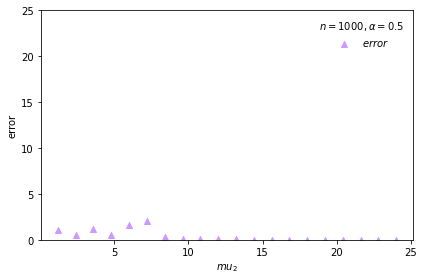

In [8]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)

mus, ests = plot_mu(N, pi, alpha, lambda_, sigma, 1.2,25.2,1.2)
plt.scatter(mus, ests, marker = '^', color = '#CC99FF', label = r'$error$', zorder = 2)

ax.set_ylim([0, 25])
ax.set_xlabel(r'$mu_2$')
ax.set_ylabel(r'error')
plt.legend(loc = 'upper right', frameon = False, title = r'$n = 1000, \alpha = 0.5$')

plt.show()

In [5]:
def gen_pi(q):
    return [(1-q)**2, 2*q*(1-q), q**2]

def get_q(pi):
    return 1 - np.sqrt(pi[0])

def single_run_q(N, q, alpha, lambda_, mu, sigma):
    X_gen = theta_to_data(N, gen_pi(q), alpha, lambda_, mu, sigma)
    q = get_q(SVMM(X_gen, False, False)[0])
    return q

def plot_q(N, alpha, lambda_, mu, sigma, start, stop, step):
    qs = np.arange(start, stop, step)
    num_runs = 10
    ests = []

    for q in qs:
        est_i = Parallel(n_jobs=-1)(delayed(single_run_q)(N, q, alpha, lambda_, mu, sigma) for _ in range(num_runs))
        ests.append(np.mean(est_i))

    return qs, ests

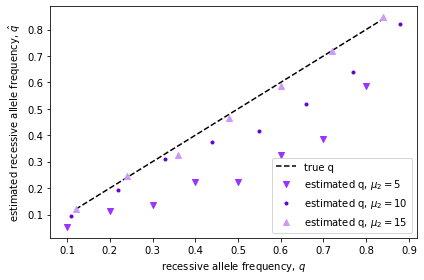

In [6]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout = True)

q_vals, ests = plot_q(N, alpha, lambda_, 5, sigma, 0.1, 0.9, .1)
plt.scatter(q_vals, ests, marker = 'v', color = '#9933FF', label = r'estimated q, $\mu_2 = 5$', zorder = 2)

q_vals, ests = plot_q(N, 0.5, lambda_, 10, sigma, 0.11, 0.91, 0.11)
plt.scatter(q_vals, ests, marker = '.', color = '#6600CC', label = r'estimated q, $\mu_2 = 10$', zorder= 3)

q_vals, ests = plot_q(N, 0.5, 5, 15, sigma, 0.12, 0.92, 0.12)
plt.scatter(q_vals, ests, marker = '^', color = '#CC99FF', label = r'estimated q, $\mu_2 = 15$', zorder= 4)

plt.plot(q_vals, q_vals, '--', color = 'black', label = 'true q', zorder = 1)

ax.set_xlabel(r'recessive allele frequency, $q$')
ax.set_ylabel(r'estimated recessive allele frequency, $\hat{q}$')

plt.legend(loc = 'lower right')

In [12]:
def AUC(N, pi, alpha, lambda_, mu_2, sigma):

    draws = multinomial.rvs(n = N, p = pi)
    draws_alpha = multinomial.rvs(n = draws[0], p = [alpha, 1 - alpha])

    X = [0 for _ in range(draws_alpha[0])]
    X_l = geom.rvs(1/lambda_, size = draws_alpha[1])
    X_g = norm.rvs(mu_2, sigma[0], size = draws[1])
    X_g2 = norm.rvs(2 * mu_2, sigma[1], size = draws[2])

    while sum(X_g < -0.5) > 0:
        X_g_new = norm.rvs(mu_2, sigma[0], size = sum(X_g < -0.5))
        X_g = [x for x in X_g if x >= -0.5]
        X_g = np.concatenate((X_g, X_g_new))

    while sum(X_g2 < -0.5) > 0:
        X_g2_new = norm.rvs(2 * mu_2, sigma[1], size = sum(X_g2 < -0.5))
        X_g2 = [x for x in X_g2 if x >= -0.5]
        X_g2 = np.concatenate((X_g2, X_g2_new))

    # X = np.concatenate((X,X_l))
    # X = np.concatenate((X,X_g))
    # X = np.concatenate((X,X_g2))
    # X = np.round(X).astype(int)

    X_g = np.round(X_g).astype(int)
    
    AUC_frac = 0
    l = np.random.choice(X_l, 1000)
    g = np.random.choice(X_g, 1000)
    for draw in range(1000):
        if l[draw] < g[draw]:
            AUC_frac += 1
    AUC_frac = AUC_frac / 1000
    
    return AUC_frac

In [13]:
def single_run(N, pi, alpha, lambda_, mu, sigma):
    return AUC(N, pi, alpha, lambda_, mu, sigma)

def plot_AUC(N, pi, alpha, lambda_, sigma, start, stop, step):
    mus = np.arange(start, stop, step)
    num_runs = 100
    ests = []
    
    for mu in mus:
        est_i = Parallel(n_jobs=-1)(delayed(single_run)(N, pi, alpha, lambda_, mu, sigma) for _ in range(num_runs))
        ests.append(np.mean(est_i))
        
    return mus, ests

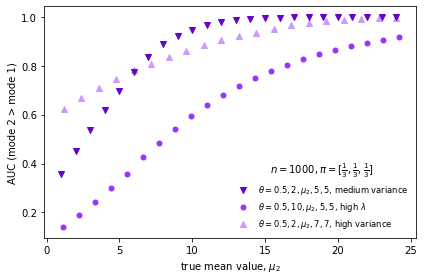

In [14]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)

mus, ests = plot_AUC(N, pi, alpha, lambda_, sigma, 1,25,1)
plt.scatter(mus, ests, marker = 'v', color = '#6600CC', label = r'$\theta = {0.5, 2, \mu_2, 5, 5}$, medium variance', zorder = 4)

mus, ests = plot_AUC(N, pi, alpha, 10, sigma, 1.1, 25.1,1.1)
plt.scatter(mus, ests, marker = '.', s = 100,color = '#9933FF',label = r'$\theta = {0.5, 10, \mu_2, 5, 5}$, high $\lambda$', zorder = 3)

mus, ests = plot_AUC(N, pi, alpha, lambda_, [7,7], 1.2,25.2,1.2)
plt.scatter(mus, ests, marker = '^', color = '#CC99FF', label = r'$\theta = {0.5, 2, \mu_2, 7, 7}$, high variance', zorder = 2)

ax.set_xlabel(r'true mean value, $\mu_2$')
ax.set_ylabel(r'AUC (mode 2 > mode 1)')
plt.legend(loc = 'lower right', fontsize = 'small', frameon = False, title = r'$n = 1000, \pi = [\frac{1}{3},\frac{1}{3},\frac{1}{3}]$')
plt.show()

In [15]:
def AUC_XgtY(N, pi, alpha, lambda_, mu_2, sigma):

    draws = multinomial.rvs(n = N, p = pi)
    draws_alpha = multinomial.rvs(n = draws[0], p = [alpha, 1 - alpha])

    X = [0 for _ in range(draws_alpha[0])]
    X_l = geom.rvs(1/lambda_, size = draws_alpha[1])
    X_g = norm.rvs(mu_2, sigma[0], size = draws[1])
    X_g2 = norm.rvs(2 * mu_2, sigma[1], size = draws[2])

    while sum(X_g < -0.5) > 0:
        X_g_new = norm.rvs(mu_2, sigma[0], size = sum(X_g < -0.5))
        X_g = [x for x in X_g if x >= -0.5]
        X_g = np.concatenate((X_g, X_g_new))

    while sum(X_g2 < -0.5) > 0:
        X_g2_new = norm.rvs(2 * mu_2, sigma[1], size = sum(X_g2 < -0.5))
        X_g2 = [x for x in X_g2 if x >= -0.5]
        X_g2 = np.concatenate((X_g2, X_g2_new))

    # X = np.concatenate((X,X_l))
    # X = np.concatenate((X,X_g))
    # X = np.concatenate((X,X_g2))
    # X = np.round(X).astype(int)

    X_g = np.round(X_g).astype(int)
    
    AUC_frac = 0
    l = np.random.choice(X_l, 1000)
    g = np.random.choice(X_g, 1000)
    for draw in range(1000):
        if l[draw] > g[draw]:
            AUC_frac += 1
    AUC_frac = AUC_frac / 1000
    
    return AUC_frac

In [16]:
def single_run(N, pi, alpha, lambda_, mu, sigma):
    return AUC_XgtY(N, pi, alpha, lambda_, mu, sigma)

def plot_AUC(N, pi, alpha, lambda_, sigma, start, stop, step):
    mus = np.arange(start, stop, step)
    num_runs = 100
    ests = []
    
    for mu in mus:
        est_i = Parallel(n_jobs=-1)(delayed(single_run)(N, pi, alpha, lambda_, mu, sigma) for _ in range(num_runs))
        ests.append(np.mean(est_i))
        
    return mus, ests

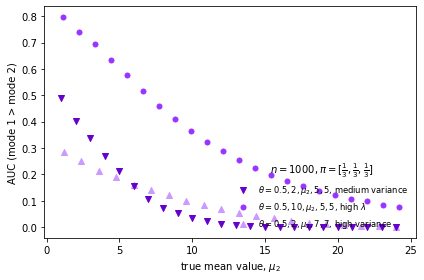

In [17]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)

mus, ests = plot_AUC(N, pi, alpha, lambda_, sigma, 1,25,1)
plt.scatter(mus, ests, marker = 'v', color = '#6600CC', label = r'$\theta = {0.5, 2, \mu_2, 5, 5}$, medium variance', zorder = 4)

mus, ests = plot_AUC(N, pi, alpha, 10, sigma, 1.1, 25.1,1.1)
plt.scatter(mus, ests, marker = '.', s = 100,color = '#9933FF',label = r'$\theta = {0.5, 10, \mu_2, 5, 5}$, high $\lambda$', zorder = 3)

mus, ests = plot_AUC(N, pi, alpha, lambda_, [7,7], 1.2,25.2,1.2)
plt.scatter(mus, ests, marker = '^', color = '#CC99FF', label = r'$\theta = {0.5, 2, \mu_2, 7, 7}$, high variance', zorder = 2)

ax.set_xlabel(r'true mean value, $\mu_2$')
ax.set_ylabel(r'AUC (mode 1 > mode 2)')
plt.legend(loc = 'lower right', fontsize = 'small', frameon = False, title = r'$n = 1000, \pi = [\frac{1}{3},\frac{1}{3},\frac{1}{3}]$')
plt.show()